<a href="https://colab.research.google.com/github/wanderson42/Turing-Academy-Projects/blob/main/TuringTalks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# --------------------------Preâmbulo-------------------------- #
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# If we're running on Colab, install PyMC
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install arviz==0.10.0 --use-deprecated=legacy-resolver
    !pip install pymc3==3.10.0

# Import pymc3 
import pymc3 as pm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# **Métodos de simulação computacional bayesiana com PyMC3**

Este tópico tem como proposta introduzir aos leitores algumas práticas de modelagem computacional utilizando técnicas bayesianas para análise de dados em problemas probabilisticos no mundo real, em particular, como fazer análise e visualização Bayesiana por meio do pacote PyMC3.

<u> PyMC3 </u> é uma biblioteca Python de programação probabilística com uma sintaxe muito simples e intuitiva para interpretar e visualizar distribuições *a posteriores*. O PyMC3 utiliza métodos de Monte Carlo via cadeias de Markov (MCMC), Uma grande vantagem do MCMC é sua flexibilidade - funciona com qualquer modelo e qualquer distribuição *a priori*. A seguir veremos o essencial para entender os dois blocos de construção de um modelo no PyMC3: Cadeias de Monte Carlo e Markov.






**Monte Carlo**

De uma forma não rigorosa, pode-se definir Monte Carlo como uma maneira de aproximar uma quantidade gerando-se números aleatórios. Por exemplo, de uma forma intuitiva, dado um circulo de raio $r=5$:


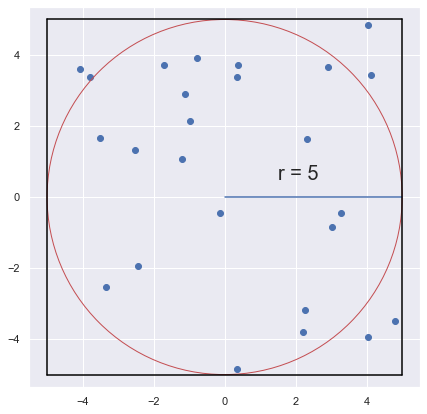

A partir da sua formula $A \sim \pi r^{2}$ sabemos que a área do circulo é $A \sim 78.5 $. Mas como podemos aproximar a área sem a fórmula?

*    Para começar, podemos definir um quadrado 10 x 10 sobre o círculo.


*    Em seguida, geramos pontos aleatórios dentro do quadrado. Quanto mais pontos, mais precisa a aproximação. 


*    Considerando apenas 25 pontos, onde 19/25 pontos = 76% caíram dentro do círculo, isto é, significa que a área do círculo é aproximadamente 76% da área do quadrado, ou : $\frac{76 \times 10\times 10}{100} \approx 76$. Nada mal usando números aleatórios!

**Cadeias de Markov**

As Cadeias de Markov são modelos de uma sequência de estados onde cada transição entre esses estados ocorre coma uma certa probabilidade. Para exemplificar imagine um urso que só caça, come e dorme. A tabela a seguir mostra as probabilidades de transição entre esses três estados.

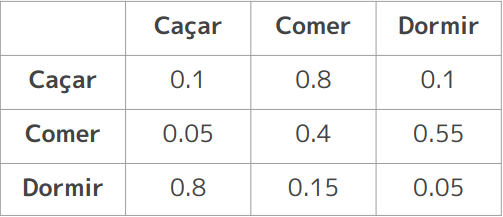

Da primeira linha, vemos que, se o urso estiver caçando agora, há 10% de probabilidade de caçar ou dormir em seguida e 80% de probabilidade de comer.

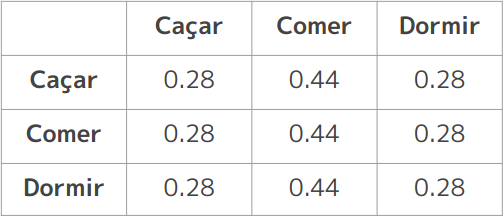

Algumas Cadeias de Markov têm a propriedade de que, após passarem de estados muitas vezes, elas atingirão o chamado estado estacionário. Isso significa que não importa onde o urso tenha começado, as probabilidades de ele estar em determinados estados em um futuro distante são as mesmas.

**Markov Chain Monte Carlo**

Agora juntando ambos os conceitos, para extrair um conjunto de diferentes valores plausíveis para os parâmetros (ou seja, os coeficientes) de um modelo probabilistico. Começamos gerando um ponto aleatório. Depois outro, próximo ao primeiro - essa é a parte de Monte Carlo, geração aleatória. Então, verificamos o quão bem esse novo ponto explica nossos dados, ou: Qual é a verossimilhança com esse valor do parâmetro. Então, aceitamos ou rejeitamos esse novo ponto. Quanto melhor explicar os dados, maior a probabilidade de aceitá-los.

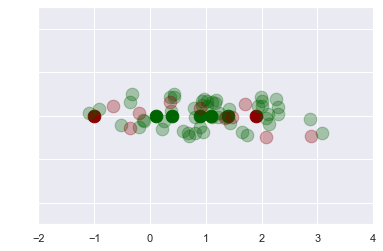


Aqui, os pontos que explicam bem nossos dados, e nós os aceitamos, estão em cor verde. Eventualmente, há muitos pontos aceitos. Isso gera uma Cadeia de Markov, e as probabilidades de amostragem de valores específicos convergem para o estado estacionário, que é nossa distribuição *a posteriori*. Finalmente, descartamos as observações iniciais, que correspondem a amostragem que antecede a convergência da Cadeia de Markov, pois são simplesmente aleatórios. Os restantes (pontos verdes mais escuros) são as melhores estimativas dos valores de parâmetros da distribuição *a posteriori*. 

Sem mais delongas agora vamos colocar todos esses conceitos em prática com um estudo de caso. Uma vez que estamos interessados em otimização de preços, decidimos aplicar esses métodos bayesianos a um conjunto de dados históricos sobre preços de abacate e volume de vendas em mercados dos EUA (O dataset pode ser encontrado aqui: https://www.kaggle.com/datasets/neuromusic/avocado-prices).


# **Estudo de caso: Estimando a elasticidade-preço na demanda (EDP)**

Após anos de aprendizado no Grupo Turing você acabou de conseguir o emprego dos sonhos: um cargo de analista de dados na "Incorporação Abacate", uma empresa que vende, sim, você adivinhou certo, abacates.

A empresa preparou alguns dados para você. Incluindo o preço do abacate por unidade da fruta, o volume vendas para um determinado preço e um indicador para classificar se a fruta é organica. A partir desse conjunto de dados você obteve um dataframe.




In [12]:
# avocado dataset
av_url = 'https://raw.githubusercontent.com/wanderson42/bayesian-data/main/avocado.csv'
avocado = pd.read_csv(av_url)
avocado.head()

,date,price,volume,type_organic
0,2015-01-04,0.95,313.242777,0
1,2015-01-11,1.01,290.635427,0
2,2015-01-18,1.03,290.434589,0
3,2015-01-25,1.04,284.703108,0
4,2015-02-01,0.89,446.554615,0


**Objetivo:** Estimar a elasticidade-preço na demanda (EDP) de abacates 
e otimizar os preços.

(elasticidade-preço = 
impacto da mudança de preço no volume de vendas)


Etapas da Abordagem Bayesiana:

**1 -** Fitar um modelo de regressão Bayesiana.

**2 -** Inspecionar a confiabilidade do modelo.

**3 -** Predizer o volume de vendas para diferentes preços e propor o preço que maximiza o lucro e mensurar a incerteza associada.


# **Etapa 1**

# Fitar um modelo de regressão Bayesiana.

Começamos por definir o modelo de regressão linear para estimar o volume de vendas:
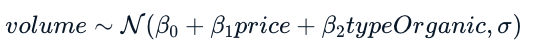



Aqui, $\beta_1$ será a EDP, ou seja, o impacto do preço nas vendas. Também você ponderou que a EDP é a mesma tanto para os abacates orgânicos e não orgânicos. Também espera-se que a EDP seja negativa: quanto mais alto for o preço, mais baixas serão as vendas (é o caso da maioria dos bens de consumo). Para incorporar este conhecimento *a priori* no modelo, uma vez familiarizado com o dataset você decide-se utilizar uma distribuição normal com média `-80` representando o termo *a priori* para o preço. 

Como se construiria um modelo deste tipo no PyMC3?

De uma forma bem simples o modelo é construido usando o dataframe e dois módulos do PyMC3, conforme se segue:

In [13]:
formula = "volume ~ price + type_organic"
with pm.Model() as model:
    priors = {"price": pm.Normal.dist(mu = -80)}
    pm.GLM.from_formula(formula, data=avocado, priors=priors)
    # Fit the model_1 using 1000 draws
    trace = pm.sample(draws = 1000, tune = 500, chains = 4, init="adapt_diag")

Explicando o código acima, definiu-se a instancia `pm.Model()` como `model` e nas instruções definiu-se: 

*    O modelo a partir da função `GLM.from_formula` passando como argumentos da função a formula "volume ~ price + type_organic", o dataframe e a distribuição *a priori*  (Vale ressaltar que se fosse o caso,  poderiamos  definir um conhecimento a priori para todas as features do modelo, assim como poderíamos definir também uma função de verossimilhança, nesse caso deixamos o "default").

*    Por fim, com a função `sample` especificamos os draws (observações) que corresponde a geração de numéros aleatórios de onde será extraido a verdadeira distribuição *a posteriori*. No processo de amostragem definimos 1000 draws válidos que correspondem ao estado estacionário e 500 draws iniciais especificados pelo parâmetro tune para fins de convergência, estes serão descartados. No parâmetro chains (cadeias) especifica-se o número de repetições independentes do processo de amostragem para o caso de alguma cadeia não convergir. Portanto no total tem-se 4000 draws para cada um dos 4 parâmetros do modelo.

# **Etapa 2**

# Inspecionar a confiabilidade do modelo.


Prezando por boas práticas de análise de dados agora os draws podem ser inspecionados por meio das funções `plot_trace` e `summary`.

                 mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept     424.669  3.326  418.333  430.771      0.070    0.050    2238.0   
price         -79.923  0.937  -81.563  -78.142      0.033    0.023     822.0   
type_organic -291.401  4.541 -300.061 -283.074      0.083    0.059    2978.0   
sd             40.924  1.632   38.086   44.185      0.031    0.022    2710.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
Intercept     2237.0    2245.0    2421.0    1.0  
price          822.0     821.0     822.0    1.0  
type_organic  2972.0    2965.0    2517.0    1.0  
sd            2685.0    2749.0    2214.0    1.0  


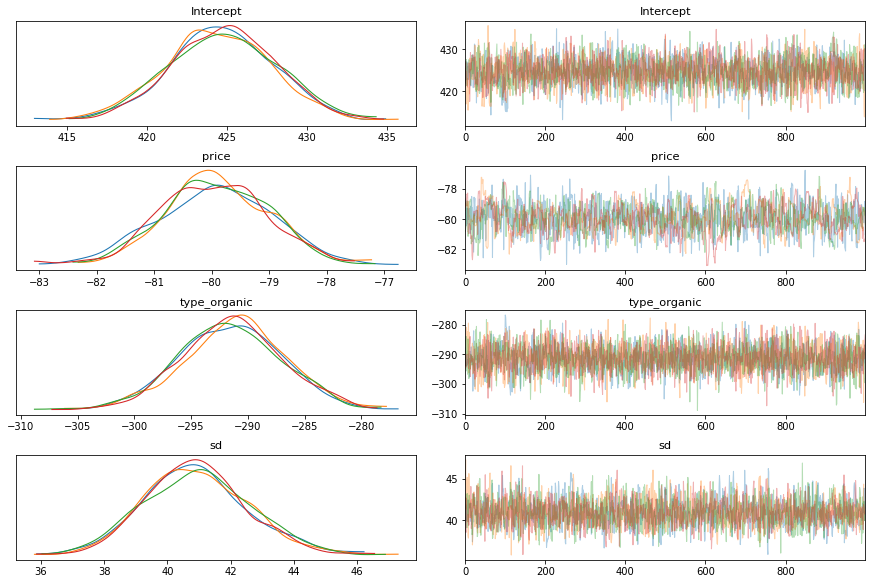

In [14]:
# Draw a trace plot of trace
pm.plot_trace(trace)

# Print a summary of trace
summary = pm.summary(trace)
print(summary)

Observando os resultados acima, começando pela função `summary` por meio desta obtêm-se uma tabela com um resumo estatistico dos dados. Nas duas primeiras colunas, podemos ver a média e o desvio padrão dos draws para cada parâmetro. Em seguida, temos as extremidades dos intervalo de credibilidade e vale destacar a última coluna chamada r_hat. Esse número só é calculado se executarmos mais de uma cadeia. Valores de r_hat maiores que 1 são um indicativo que cadeias de Markov não convergiram. Em relação a função `plot_trace`, esta produz dois subplots por parâmetro: 

*    À esquerda, temos o gráfico da função de densidade *a posteriori*. Há quatro linhas por parâmetro em cada subplot, uma para cada cadeia de Markov. O fato de serem todos semelhantes é um indicativo de confiabilidade do modelo. Apesar de ocorrer uma pequena instabilidade em uma das cadeias de `price` sua densidade ainda está bem próxima das outras.

*    À direita, temos os gráficos dos 4000 draws por cadeia. Percebe-se que estes oscilam com amplitude em torno de alguma média constante, o que prova uma boa convergência. Assim, em suma, não precisamos nos preocupar com isso e podemos usar o modelo com segurança para otimizar o preço!

# **Etapa 3**

# Otimizar o preço e mensurar a incerteza associada.

**Uma vez efetuado a inspeção do modelo! Agora, vamos ao que interessa: Seu chefe pediu que você forneça o preço do abacate que maximiza o lucro e qual lucro pode ser esperado. Além disso, ele quer que o preço seja divisível por US$ 0.25 para que os clientes possam pagar facilmente com quarto de dolar.**

Neste caso você deve-se utilizar o modelo desenvolvido para prever o volume e o lucro considerando alguns preços razoáveis. Em seguida, você visualizará as distribuições preditivas para escolher o preço ideal. Por fim, você ira calcular o intervalo de credibilidade de previsão de lucro.

Para isso é necessário calcular a média da distribuição *a posteriori* dos 4 parâmetros obtidos anteriormente. Assim sendo:

In [15]:
# Get each parameter's posterior mean
intercept_mean = np.mean(trace.get_values("Intercept")) 
price_mean = np.mean(trace.get_values("price"))
organic_mean = np.mean(trace.get_values("type_organic"))
sd_mean = np.mean(trace.get_values("sd"))

Para cada preço provável que maxima o lucro calcula-se a média preditiva para obter a amostragem da distribuição do volume de vendas e assim usar o volume predito para prever o lucro. Conforme se segue:




In [16]:
# For each price, predict volume and use it to predict profit
predicted_profit_per_price = {}
for price in [0.5, 0.75, 1, 1.25]:
    pred_mean = (intercept_mean + price_mean*price + organic_mean)
    volume_pred = np.random.normal(pred_mean, sd_mean, size=1000)
    profit_pred = price * volume_pred
    predicted_profit_per_price.update({price: profit_pred})

Por fim, plotamos um gráfico em floresta do lucro predito:

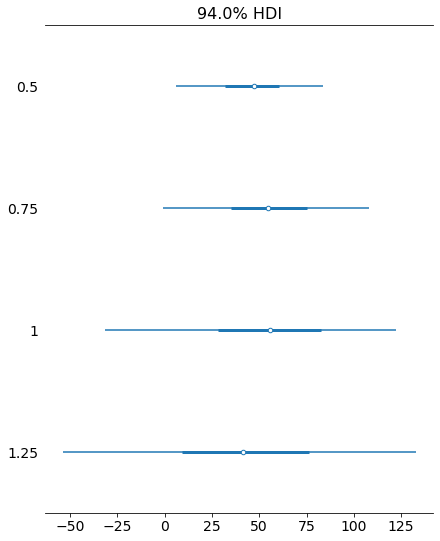

In [17]:
# Draw a forest plot of predicted profit for all prices
pm.plot_forest(predicted_profit_per_price)
plt.show()

Vale ressaltar que optar por esse tipo de gráfico em floresta é uma escolha conveniente ao invés de gráficos de densidade usando seaborn, onde tudo ficaria muito confuso. Para implementar o gráfico em floresta, conforme o código acima, só foi necessário criar um dicionário que denota o lucro predito conforme o preço estipulado. Conforme os resultados acima cada densidade é representada com uma linha azul no gráfico. A linha mais grossa no meio de cada densidade denota o intervalo interquartil, enquanto que as linhas mais finas mostram o intervalo de credibilidade de 94% \(que é o default do PyMC3). 

Baseado nesses resultados a escolha que maxima o lucro é US$ 0.75. Agora conhecendo o preço ideal, pode-se melhorar o cálculo de intervalo de credibilidade para 99%, onde a chance de previsão para o caso de lucro (valores positivos) ou prejuizo (valores negativos) não cair nesse intervalo é de 1%, portando sendo muito improvável um erro de estimativa fora desse intervalo.

In [18]:
# Calculate and print HPD of predicted profit for the optimal price
opt_hpd = pm.hpd(predicted_profit_per_price[0.75],hdi_prob = 0.99)
print("Intervalo de credibilidade:", opt_hpd)

Intervalo de credibilidade: [-18.57542144 131.69918691]


/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


Ótimo trabalho! Com um preço de abacate mais alto (US\$ 1.25) ou mais baixo (US\$ 0.5), sua empresa perderia lucro, mas graças às suas habilidades com estatistica bayesiana, eles conseguiram definir o melhor preço possível. Mais do que isso, sabendo da incerteza na previsão do lucro, eles podem se preparar até para o pior cenário (no qual o lucro é negativo!).